In [84]:
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.metrics import classification_report
from keras.models import model_from_json

from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

import pandas as pd
import numpy as np
import os

In [128]:
#Everything I need from the other notebook to load
time = pd.read_csv("/content/drive/My Drive/Crypto/time.csv")
LGR_model = pickle.load(open("/content/drive/My Drive/Crypto/CryptoLGR_model.sav", "rb"))
LGR2_model = pickle.load(open("/content/drive/My Drive/Crypto/CryptoLGR2_model.sav", "rb"))
LGR3_model = pickle.load(open("/content/drive/My Drive/Crypto/CryptoLGR3_model.sav", "rb"))
LGR4_model = pickle.load(open("/content/drive/My Drive/Crypto/CryptoLGR4_model.sav", "rb"))

XBG_model = pickle.load(open("/content/drive/My Drive/Crypto/XGBC_model.sav", "rb"))
XBG2_model = pickle.load(open("/content/drive/My Drive/Crypto/XGBC2_model.sav", "rb"))
XBG3_model = pickle.load(open("/content/drive/My Drive/Crypto/XGBC3_model.sav", "rb"))
XBG4_model = pickle.load(open("/content/drive/My Drive/Crypto/XGBC4_model.sav", "rb"))

lstm_df = pd.read_csv(r"/content/drive/My Drive/Crypto/lstm_df.csv")
lstm_model = keras.models.load_model("/content/drive/My Drive/Crypto/lstm_model.h5")
lstm_model.load_weights("/content/drive/My Drive/Crypto/lstm_model_weights.h5")
y_test = pd.read_csv(r"/content/drive/My Drive/Crypto/y_test.csv")
LGR_predictions = np.loadtxt("/content/drive/My Drive/Crypto/LGR_predictions.txt")
XGB_predictions = np.loadtxt("/content/drive/My Drive/Crypto/XGB_predictions.txt")

pca2 = np.loadtxt("/content/drive/My Drive/Crypto/LGR2_X.txt")
pca3 = np.loadtxt("/content/drive/My Drive/Crypto/LGR3_X.txt")
pca4 = np.loadtxt("/content/drive/My Drive/Crypto/LGR4_X.txt")

xpca2 = np.loadtxt("/content/drive/My Drive/Crypto/XGB2_predictions.txt")
xpca3 = np.loadtxt("/content/drive/My Drive/Crypto/XGB3_predictions.txt")
xpca4 = np.loadtxt("/content/drive/My Drive/Crypto/XGB4_predictions.txt")

In [86]:
#This is pretty messed up!
print("Log regression classification report is: ","\n", classification_report(y_test,LGR_predictions))

Log regression classification report is:  
               precision    recall  f1-score   support

           0       0.44      0.57      0.50     91259
           1       0.58      0.45      0.51    118981

    accuracy                           0.50    210240
   macro avg       0.51      0.51      0.50    210240
weighted avg       0.52      0.50      0.50    210240



In [87]:
#... 
print("XGB regression classification report is: ","\n", classification_report(y_test,XGB_predictions))

XGB regression classification report is:  
               precision    recall  f1-score   support

           0       0.39      0.00      0.00     91259
           1       0.57      1.00      0.72    118981

    accuracy                           0.57    210240
   macro avg       0.48      0.50      0.36    210240
weighted avg       0.49      0.57      0.41    210240



In [88]:
def convert_data(data, step):
  X, y = [], []
  for i in range(len(data)-step):
    d = i + step
    X.append(data[i:d,:-1])
    y.append(data[d,-1])
  return np.array(X), np.array(y)

In [89]:
X_train, y_train = convert_data(lstm_df[:788400].values, 30)
X_test, y_test = convert_data(lstm_df[788401:].values, 30)

lstm_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (lstm_model.metrics_names[1], score[1]*100))

8212/8212 [==============================] - 26s 3ms/step - loss: 0.6856 - accuracy: 0.5661
accuracy: 56.61%


In [90]:
print(len(y_test))
print(len(LGR_predictions))

262769
210240


In [91]:
time.drop(columns = 'time', inplace = True)
lstm_df = lstm_df.join(time, how = "left")
#resize to fit predictions
lstm_df = lstm_df[-210240:]
lstm_df['LGR_predictions'] = LGR_predictions
lstm_df['XGB_predictions'] = XGB_predictions

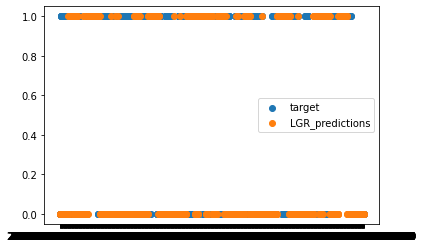

In [92]:
#amont in 1 day
plt.scatter(x="time.1", y = "target", data=lstm_df[-1440:])
plt.scatter(x="time.1", y = "LGR_predictions", data=lstm_df[-1440:])
plt.legend()
plt.show()

In [104]:
# #Show amount earned based on LGR predictions
# #I'm not a wealthy man
one_day_df = lstm_df[-10080:]
potential_initial_investment = 1000
potential_money_earned = 0
potential_holdings = 0
potential_status = 0
actual_initial_investment = 1000
actual_money_earned = 0
actual_holdings = 0
actual_status = 0
# 0 Statusmeans we are not holding money. If status is 1, we are invested

for i in range(len(one_day_df)):
  if (one_day_df.iloc[i]['target']==1 and potential_status ==0):
    amount_invested = potential_initial_investment*.3
    potential_holdings = (amount_invested)/(one_day_df.iloc[i]['close'])
    potential_status = 1
    potential_initial_investment = potential_initial_investment-amount_invested

  elif (one_day_df.iloc[i]['target']==0 and potential_status ==1):
    potential_money_earned = potential_holdings*one_day_df.iloc[i]['close']
    potential_initial_investment += potential_money_earned
    potential_status = 0
  else:
    pass


for i in range(len(one_day_df)):
  if (one_day_df.iloc[i]['LGR_predictions']==1 and actual_status == 0):
    amount_invested = actual_initial_investment*.3
    actual_holdings = (amount_invested)/(one_day_df.iloc[i]['close'])
    actual_status = 1
    actual_initial_investment = actual_initial_investment-amount_invested

  elif (one_day_df.iloc[i]['LGR_predictions']==0 and actual_status == 1):
    actual_money_earned = actual_holdings*one_day_df.iloc[i]['close']
    actual_initial_investment += actual_money_earned
    actual_status = 0
  else:
    pass

In [105]:
#My god this is a crazy strategy
potential_initial_investment


983.1263994996809

In [106]:
#Damn, I lose money. That's not a good strategy
actual_initial_investment


984.1891320382574

In [ ]:
#Well poop. Let's see if the unsupervised learning helped at all

In [124]:
pca4

array([1., 1., 1., ..., 0., 0., 0.])

In [125]:
#PCA doesn't really do anything for Log regression, let's see if it does something for XGB boosting
print("PCA 2 Log regression classification report is: ","\n", classification_report(y_test,pca2))
print("PCA 3 Log regression classification report is: ","\n", classification_report(y_test,pca3))
print("PCA 4 Log regression classification report is: ","\n", classification_report(y_test,pca4))

PCA 2 Log regression classification report is:  
               precision    recall  f1-score   support

           0       0.48      0.35      0.40    103456
           1       0.50      0.64      0.56    106784

    accuracy                           0.50    210240
   macro avg       0.49      0.49      0.48    210240
weighted avg       0.49      0.50      0.48    210240

PCA 3 Log regression classification report is:  
               precision    recall  f1-score   support

           0       0.53      0.53      0.53    103456
           1       0.55      0.55      0.55    106784

    accuracy                           0.54    210240
   macro avg       0.54      0.54      0.54    210240
weighted avg       0.54      0.54      0.54    210240

PCA 4 Log regression classification report is:  
               precision    recall  f1-score   support

           0       0.53      0.53      0.53    103456
           1       0.55      0.55      0.55    106784

    accuracy                    

In [130]:
#Not really super helpful
print("PCA 2 XGB regression classification report is: ","\n", classification_report(y_test,xpca2))
print("PCA 3 XGB regression classification report is: ","\n", classification_report(y_test,xpca3))
print("PCA 4 XGB regression classification report is: ","\n", classification_report(y_test,xpca4))

PCA 2 XGB regression classification report is:  
               precision    recall  f1-score   support

           0       0.48      0.25      0.33    103456
           1       0.50      0.74      0.60    106784

    accuracy                           0.50    210240
   macro avg       0.49      0.49      0.46    210240
weighted avg       0.49      0.50      0.46    210240

PCA 3 XGB regression classification report is:  
               precision    recall  f1-score   support

           0       0.53      0.44      0.48    103456
           1       0.53      0.62      0.58    106784

    accuracy                           0.53    210240
   macro avg       0.53      0.53      0.53    210240
weighted avg       0.53      0.53      0.53    210240

PCA 4 XGB regression classification report is:  
               precision    recall  f1-score   support

           0       0.53      0.47      0.50    103456
           1       0.54      0.60      0.57    106784

    accuracy                    